In [ ]:
import numpy as np
import pandas as pd
import json
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from joblib import parallel_backend
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)
SEED = 42

In [2]:
train_df = pd.read_csv("Tables/bnpl_train.csv")
test_df = pd.read_csv("Tables/bnpl_test.csv")
val_df = pd.read_csv("Tables/bnpl_val.csv")
target_col = "default_flag"


In [3]:
print(train_df.shape, test_df.shape, val_df.shape)
print(train_df.head(),test_df.head(), val_df.head())
print("Train nulls in target:", train_df["default_flag"].isna().sum())
print("Train class distribution:\n", train_df["default_flag"].value_counts(normalize=True))

(595, 14) (199, 14) (199, 14)
   external_repayment_loans  credit_card_interest_incidence  default_flag  \
0                         1                               0             0   
1                         0                               0             0   
2                         0                               0             0   
3                         0                               1             0   
4                         1                               1             0   

   bnpl_usage_frequency  financial_stress_score  credit_limit_utilisation  \
0             -0.730258               -1.246089                 -1.746734   
1              1.319109                0.529472                 -0.222965   
2              0.408279                1.239697                  0.805578   
3             -1.641088                1.594809                 -0.184871   
4              0.408279                0.529472                 -1.556263   

   payment_delinquency_count  impulsive_buyi

In [4]:
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
print("X_train shape:", X_train.shape, X_train.head())
print("y_train shape:", y_train.shape, y_train.head())
X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]
print("X_test shape:", X_test.shape, X_test.head())
print("y_test shape:", y_test.shape, y_test.head())
X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]
print("X_val shape:", X_val.shape, X_val.head())
print("y_val shape:", y_val.shape, y_val.head())

X_train shape: (595, 13)    external_repayment_loans  credit_card_interest_incidence  \
0                         1                               0   
1                         0                               0   
2                         0                               0   
3                         0                               1   
4                         1                               1   

   bnpl_usage_frequency  financial_stress_score  credit_limit_utilisation  \
0             -0.730258               -1.246089                 -1.746734   
1              1.319109                0.529472                 -0.222965   
2              0.408279                1.239697                  0.805578   
3             -1.641088                1.594809                 -0.184871   
4              0.408279                0.529472                 -1.556263   

   payment_delinquency_count  impulsive_buying_score  \
0                  -1.500097               -0.528311   
1                  -1

In [23]:
k_values = range(2, 13)
results = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50, max_iter=500)
    kmeans.fit(X_train)
    labels = kmeans.labels_
    
    inertia = kmeans.inertia_
    sil = silhouette_score(X_train, labels)
    ch = calinski_harabasz_score(X_train, labels)
    db = davies_bouldin_score(X_train, labels)
    
    results.append({"k": k, "inertia": inertia, "silhouette": sil, "CH": ch, "DB": db})

results_df = pd.DataFrame(results)
print(results_df)

     k      inertia  silhouette         CH        DB
0    2  6290.553294    0.070645  45.835056  3.548528
1    3  5872.181746    0.084116  45.597839  2.892671
2    4  5485.651994    0.097166  46.366539  2.544913
3    5  5254.740466    0.086082  42.723269  2.481692
4    6  5072.438114    0.079441  39.580683  2.390039
5    7  4915.715464    0.078621  37.102141  2.266018
6    8  4784.019710    0.077845  34.930152  2.236719
7    9  4671.524077    0.078978  33.010518  2.227642
8   10  4545.151502    0.083193  31.914305  2.174339
9   11  4448.804034    0.080424  30.559527  2.129047
10  12  4378.951624    0.081840  29.021671  2.168859


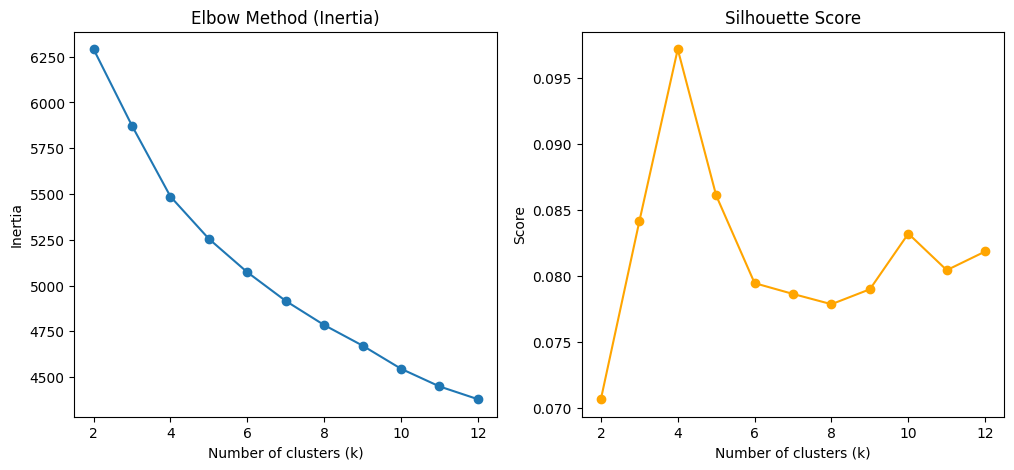

In [25]:


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(results_df["k"], results_df["inertia"], marker='o')
plt.title("Elbow Method (Inertia)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(results_df["k"], results_df["silhouette"], marker='o', color='orange')
plt.title("Silhouette Score")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Score")
plt.savefig('Plots/Kmeans_Silhouette.png')
plt.show()

In [26]:
# Step 3.1 — Combine train + validation features for final training
X_trainval = np.vstack([X_train, X_val])

# Step 3.2 — Fit final k-means model
final_kmeans = KMeans(
    n_clusters=2, init="k-means++", n_init=50, max_iter=500, random_state=42
)
final_kmeans.fit(X_trainval)

# Step 3.3 — Assign clusters to each split
train_clusters = final_kmeans.predict(X_train)
val_clusters   = final_kmeans.predict(X_val)
test_clusters  = final_kmeans.predict(X_test)

C:\Users\ismai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\ismai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\ismai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [27]:
K_train=train_df.copy()
K_train['cluster'] = train_clusters
K_val=val_df.copy()
K_val['cluster'] = val_clusters
K_test=test_df.copy()
K_test['cluster'] = test_clusters

In [28]:
def cluster_default_rates(df):
    return df.groupby("cluster")["default_flag"].agg(
        cluster_size="count",
        default_rate="mean"
    ).sort_values("default_rate", ascending=False)

train_cluster_stats = cluster_default_rates(K_train)
val_cluster_stats   = cluster_default_rates(K_val)
test_cluster_stats  = cluster_default_rates(K_test)

print("Train Cluster Default Rates:\n", train_cluster_stats)
print("\nValidation Cluster Default Rates:\n", val_cluster_stats)
print("\nTest Cluster Default Rates:\n", test_cluster_stats)


Train Cluster Default Rates:
          cluster_size  default_rate
cluster                            
1                 292      0.082192
0                 303      0.072607

Validation Cluster Default Rates:
          cluster_size  default_rate
cluster                            
1                  98      0.081633
0                 101      0.079208

Test Cluster Default Rates:
          cluster_size  default_rate
cluster                            
1                 110       0.10000
0                  89       0.05618


In [29]:
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
print("X_train shape:", X_train.shape, X_train.head())
print("y_train shape:", y_train.shape, y_train.head())
X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]
print("X_test shape:", X_test.shape, X_test.head())
print("y_test shape:", y_test.shape, y_test.head())
X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]
print("X_val shape:", X_val.shape, X_val.head())
print("y_val shape:", y_val.shape, y_val.head())

X_train shape: (595, 13)    external_repayment_loans  credit_card_interest_incidence  \
0                         1                               0   
1                         0                               0   
2                         0                               0   
3                         0                               1   
4                         1                               1   

   bnpl_usage_frequency  financial_stress_score  credit_limit_utilisation  \
0             -0.730258               -1.246089                 -1.746734   
1              1.319109                0.529472                 -0.222965   
2              0.408279                1.239697                  0.805578   
3             -1.641088                1.594809                 -0.184871   
4              0.408279                0.529472                 -1.556263   

   payment_delinquency_count  impulsive_buying_score  \
0                  -1.500097               -0.528311   
1                  -1

In [30]:
x_k_train=K_train.drop(columns=[target_col])
x_k_val=K_val.drop(columns=[target_col])
x_k_test=K_test.drop(columns=[target_col])
y_k_train=K_train[target_col]
y_k_val=K_val[target_col]
y_k_test=K_test[target_col]

In [ ]:
# Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,      # Let it grow until pure leaves or min_samples constraints
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(x_k_train, y_k_train)

# Predictions
rf_preds = rf_model.predict(x_k_val)
rf_probs = rf_model.predict_proba(x_k_val)[:, 1]

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_k_val, rf_preds))
print("ROC AUC Score:", roc_auc_score(y_k_val, rf_probs))
print("F1 Score:", f1_score(y_k_val, rf_preds))
print("Recall Score:", recall_score(y_k_val, rf_preds))
print("Precision Score:", precision_score(y_k_val, rf_preds))


Confusion Matrix:
 [[183   0]
 [  4  12]]
ROC AUC Score: 0.9996584699453552
F1 Score: 0.8571428571428571
Recall Score: 0.75
Precision Score: 1.0


In [48]:
#get the threshold for the best f1 score
precision, recall, thresholds = precision_recall_curve(y_k_val, rf_probs)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_f1_index = np.argmax(f1_scores)
best_f1_threshold = thresholds[best_f1_index]
print("Best F1 Score Threshold:", best_f1_threshold)
# Apply the best threshold to get final predictions
rf_final_preds = (rf_probs >= best_f1_threshold).astype(int)
# Final evaluation with the best threshold
print("Final Random Forest Classification Report with Best F1 Threshold:\n", classification_report(y_k_val, rf_final_preds))


Best F1 Score Threshold: 0.2966666666666667
Final Random Forest Classification Report with Best F1 Threshold:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       183
           1       0.94      1.00      0.97        16

    accuracy                           0.99       199
   macro avg       0.97      1.00      0.98       199
weighted avg       1.00      0.99      1.00       199



In [61]:
rf_f_probs = rf_model.predict_proba(x_k_test)[:, 1]
rf_f_preds = (rf_f_probs >= best_f1_threshold).astype(int)

In [62]:
print(confusion_matrix(y_k_test, rf_f_preds))

[[183   0]
 [  3  13]]


In [63]:
fpr, tpr, thresholds = roc_curve(y_k_test, rf_f_probs)
results = {
    "threshold": float(best_f1_threshold),
    "confusion_matrix": confusion_matrix(y_k_test, rf_f_preds).tolist(),
    "accuracy": accuracy_score(y_k_test, rf_f_preds),
    "precision": precision_score(y_k_test, rf_f_preds),
    "recall": recall_score(y_k_test, rf_f_preds),
    "f1_score": f1_score(y_k_test, rf_f_preds),
    "roc_auc": roc_auc_score(y_k_test, rf_f_preds),
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist(),
    "roc_thresholds": thresholds.tolist(),    
}
print (results)
with open("Results\K-Means_RF_model_results.json", "w") as f:
    json.dump(results, f)

{'threshold': 0.2966666666666667, 'confusion_matrix': [[183, 0], [3, 13]], 'accuracy': 0.9849246231155779, 'precision': 1.0, 'recall': 0.8125, 'f1_score': 0.896551724137931, 'roc_auc': 0.90625, 'fpr': [0.0, 0.0, 0.0, 0.0, 0.0, 0.00546448087431694, 0.00546448087431694, 0.01092896174863388, 0.02185792349726776, 0.04918032786885246, 0.060109289617486336, 0.07650273224043716, 0.09289617486338798, 0.11475409836065574, 0.12568306010928962, 0.14754098360655737, 0.14754098360655737, 0.16393442622950818, 0.17486338797814208, 0.20765027322404372, 0.21311475409836064, 0.2568306010928962, 0.2896174863387978, 0.32786885245901637, 0.3825136612021858, 0.4098360655737705, 0.4207650273224044, 0.4426229508196721, 0.46994535519125685, 0.5081967213114754, 0.5355191256830601, 0.6120218579234973, 0.6939890710382514, 0.819672131147541, 1.0], 'tpr': [0.0, 0.125, 0.25, 0.5, 0.875, 0.875, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [68]:
# Fit without early stopping:
XG_model = XGBClassifier(random_state=SEED,
                      use_label_encoder=False,
                      eval_metric="logloss")  

XG_model.fit(x_k_train, y_k_train)

# Predict & evaluate:
y_valid_proba = XG_model.predict_proba(x_k_val)[:, 1]
auc = roc_auc_score(y_val, y_valid_proba)
print(f"Validation ROC AUC: {auc:.4f}")


Validation ROC AUC: 1.0000


C:\Users\ismai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [20:36:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [73]:

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

rs = RandomizedSearchCV(
    estimator=XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=SEED,
        n_jobs=1,               # avoid nested process pools in XGBoost
    ),
    param_distributions=param_dist,
    n_iter=50,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    n_jobs=-1,                 # we’ll turn this into threads below
    random_state=SEED
)

with parallel_backend("threading"):    # <- uses threads, no subprocess spawn
    rs.fit(x_k_train, y_k_train)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\ismai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [20:38:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [74]:
best_params = rs.best_params_

# Re-instantiate with best params
best_model = XGBClassifier(
    **best_params,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=SEED
)

# Fit on train + valid (optional) or just train
best_model.fit(
    x_k_train,
    y_k_train,
    # if your version supports it:
    #early_stopping_rounds=10,
    eval_set=[(x_k_val, y_k_val)],
    verbose=False
)

# Final AUC on the validation set:
y_valid_proba = best_model.predict_proba(x_k_val)[:, 1]
print("Tuned model ROC AUC on valid: ",
      roc_auc_score(y_k_val, y_valid_proba))


C:\Users\ismai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [20:39:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tuned model ROC AUC on valid:  1.0


In [75]:
print("Best CV AUC (3-fold on train):", rs.best_score_)
print("Best hyperparameters:", rs.best_params_)


Best CV AUC (3-fold on train): 0.9991955069823922
Best hyperparameters: {'subsample': 1.0, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.8}


In [80]:

def best_threshold_by_f1(y_true, p):
    # p = predicted probability of the positive class
    prec, rec, thr = precision_recall_curve(y_true, p)
    f1 = (2 * prec * rec) / (prec + rec + 1e-12)
    i = np.nanargmax(f1)
    # precision_recall_curve returns thresholds of length n-1
    best_thr = thr[i-1] if i > 0 else 1.0
    return float(best_thr), float(f1[i]), float(prec[i]), float(rec[i])

# ---- use on VALIDATION ----
p_val = best_model.predict_proba(x_k_val)[:, 1]
thr, f1, prec, rec = best_threshold_by_f1(y_k_val, p_val)
print(f"Best threshold={thr:.4f}, F1={f1:.4f} (P={prec:.4f}, R={rec:.4f})")


Best threshold=0.0947, F1=1.0000 (P=1.0000, R=1.0000)


In [83]:
thr

0.09474921226501465

In [84]:
print("Evaluating on the test set...")
y_proba_pos = best_model.predict_proba(x_k_test)[:, 1]
y_pred      = (y_proba_pos >= thr).astype(int)

Evaluating on the test set...


In [85]:
print("Confusion matrix:\n", confusion_matrix(y_k_test, y_pred))
print("Precision, Recall, F1-score, AUC:")
print("Precision:", precision_score(y_k_test, y_pred))
print("Recall:", recall_score(y_k_test, y_pred))
print("F1-score:", f1_score(y_k_test, y_pred))
print("AUC:", roc_auc_score(y_k_test, y_proba_pos))

Confusion matrix:
 [[183   0]
 [  1  15]]
Precision, Recall, F1-score, AUC:
Precision: 1.0
Recall: 0.9375
F1-score: 0.967741935483871
AUC: 1.0


In [86]:
fpr, tpr, thresholds = roc_curve(y_k_test, y_pred)
# Calculate metrics
results = {
    "threshold": 0.5,  # Default threshold, can be adjusted based on validation set
    "confusion_matrix": confusion_matrix(y_k_test, y_pred).tolist(),  # Convert to list for JSON compatibility
    "accuracy": accuracy_score(y_k_test, y_pred),
    "precision": precision_score(y_k_test, y_pred),
    "recall": recall_score(y_k_test, y_pred),
    "f1_score": f1_score(y_k_test, y_pred),
    "roc_auc": roc_auc_score(y_k_test, y_proba_pos),
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist(),
    "roc_thresholds": thresholds.tolist(),
}
print(results)
# Save results to a JSON file
with open("Results\K-Means_XGB_model_results.json", "w") as json_file:
    json.dump(results, json_file, indent=4)


{'threshold': 0.5, 'confusion_matrix': [[183, 0], [1, 15]], 'accuracy': 0.9949748743718593, 'precision': 1.0, 'recall': 0.9375, 'f1_score': 0.967741935483871, 'roc_auc': 1.0, 'fpr': [0.0, 0.0, 1.0], 'tpr': [0.0, 0.9375, 1.0], 'roc_thresholds': [inf, 1.0, 0.0]}


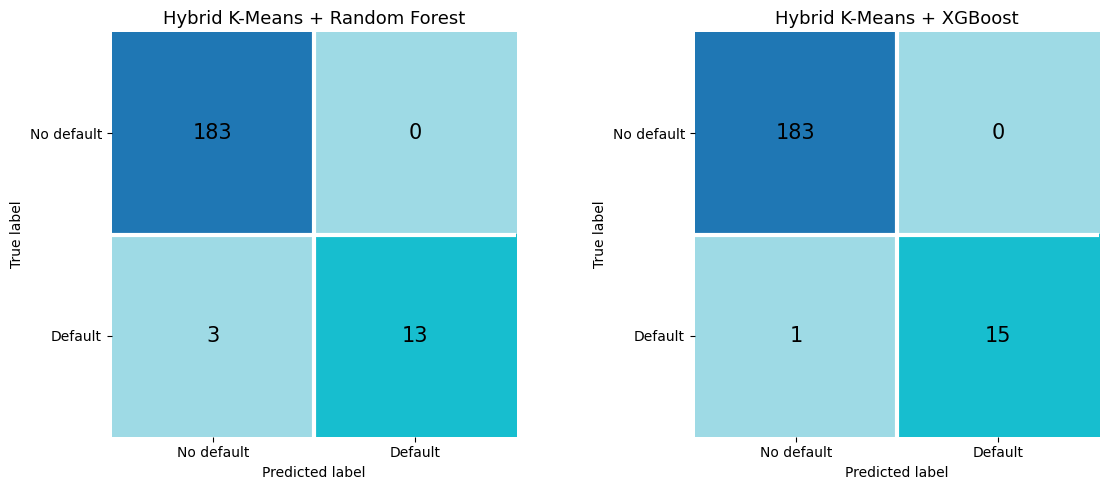

In [88]:

# Compute confusion matrices
cm_rf = confusion_matrix(y_k_test, rf_f_preds, labels=[0, 1])
cm_xgb = confusion_matrix(y_k_test, y_pred, labels=[0, 1])

# Create a figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Function to apply custom style
def plot_cm(cm, ax, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No default', 'Default'])
    disp.plot(values_format='d', cmap='tab20_r', ax=ax, colorbar=False)

    # Make the numbers bigger and black
    for text in disp.text_.ravel():
        text.set_fontsize(15)
        text.set_color('black')

    # Add white grid lines
    n_classes = cm.shape[0]
    for i in range(1, n_classes):
        ax.axhline(i - 0.5, color='white', linewidth=3)
        ax.axvline(i - 0.5, color='white', linewidth=3)

    # Remove outer border
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Set title
    ax.set_title(title, fontsize=13)

# Plot both matrices
plot_cm(cm_rf, axes[0], "Hybrid K-Means + Random Forest")
plot_cm(cm_xgb, axes[1], "Hybrid K-Means + XGBoost")

plt.tight_layout()
plt.savefig("Plots/Confusion Matricies/K-Means_cm.png")
plt.show()


In [89]:
#get the top features for both models
# Feature importance for Random Forest
importances = rf_model.feature_importances_
feature_names = x_k_train.columns
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True)
feature_importance_clean = feature_importance[feature_importance['Feature'] != 'cluster']
print("RF Feature Importance:\n", feature_importance_clean.head(6))
feature_importance_clean.head(6).to_csv("Results/kmeans_rf_feature_importance.csv", index=False)


RF Feature Importance:
                      Feature  Importance
0       bnpl_usage_frequency    0.163474
1            bnpl_debt_ratio    0.162226
2   stress_usage_interaction    0.134855
3     financial_stress_score    0.129335
4  payment_delinquency_count    0.117098
5   credit_limit_utilisation    0.094124


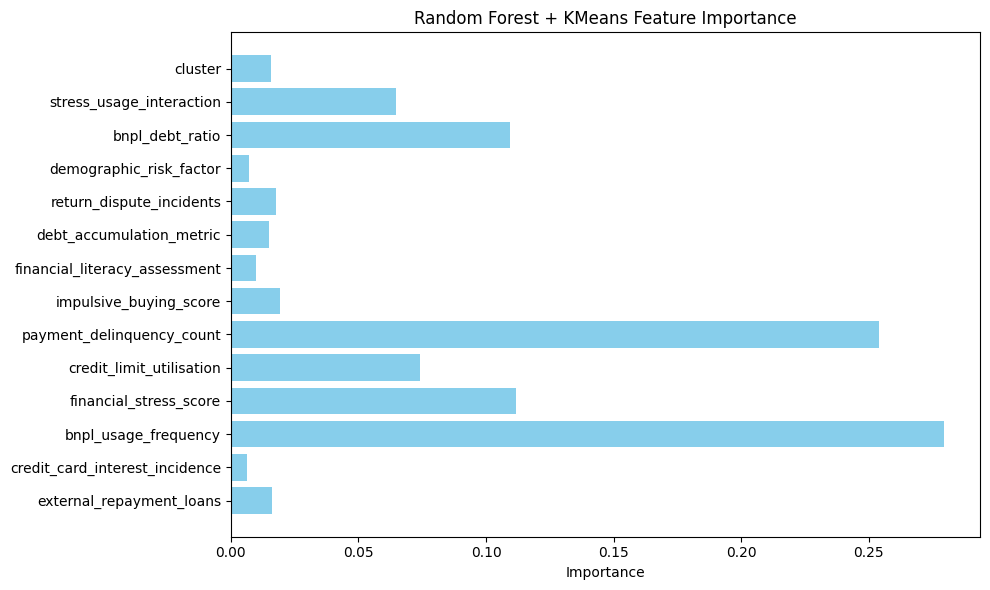

In [90]:
# Plot feature importance
plt.figure(figsize=(10, 6))
importances = xgb_model.feature_importances_
feature_names = x_k_train.columns
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel("Importance")
plt.title("Random Forest + KMeans Feature Importance")
plt.tight_layout()


In [91]:
# Feature importance for XGBoost
importances = xgb_model.feature_importances_
feature_names = x_k_train.columns
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)
display(feature_importance.head(7))
# i want to remove the cluster feature from the importance list


,Feature,Importance
0,bnpl_usage_frequency,0.279583
1,payment_delinquency_count,0.254089
2,financial_stress_score,0.111894
3,bnpl_debt_ratio,0.109197
4,credit_limit_utilisation,0.074202
5,stress_usage_interaction,0.064793
6,impulsive_buying_score,0.019108


In [92]:
feature_importance_clean = feature_importance[feature_importance['Feature'] != 'cluster']
print("XGBoost Feature Importance:\n", feature_importance_clean.head(6))
feature_importance_clean.head(6).to_csv("Results/kmeans_xgb_feature_importance.csv", index=False)

XGBoost Feature Importance:
                      Feature  Importance
0       bnpl_usage_frequency    0.279583
1  payment_delinquency_count    0.254089
2     financial_stress_score    0.111894
3            bnpl_debt_ratio    0.109197
4   credit_limit_utilisation    0.074202
5   stress_usage_interaction    0.064793


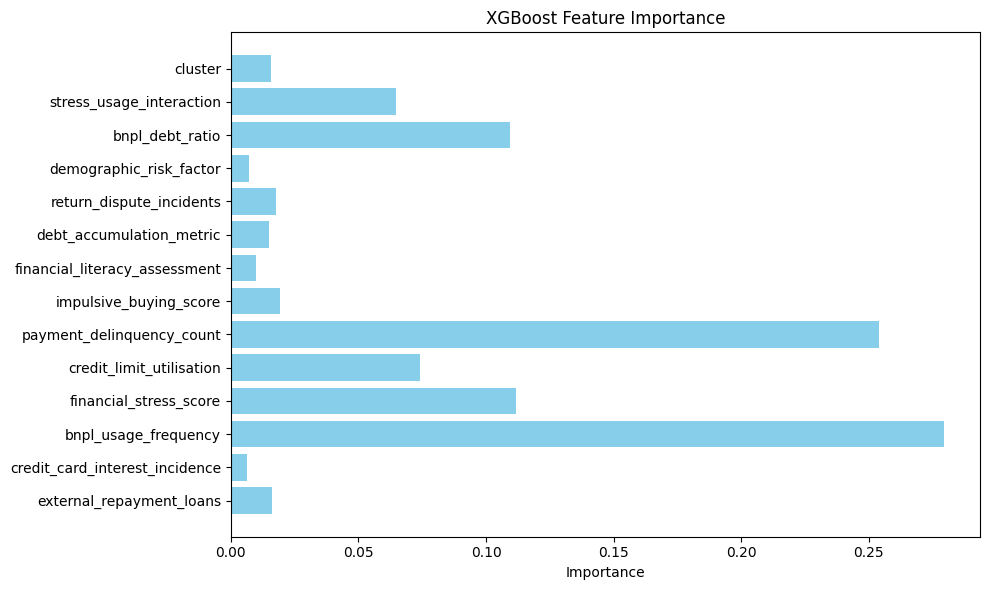

In [93]:
# Plot feature importance
plt.figure(figsize=(10, 6))
importances = xgb_model.feature_importances_
feature_names = x_k_train.columns
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel("Importance")
plt.title("XGBoost Feature Importance")
plt.tight_layout()